# Vector-based Personalization

In [1]:
import os
import random
import pickle
from collections import defaultdict
from datetime import datetime
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy
import seaborn as sns
import sklearn.cluster as cluster
from aips import get_engine, display_product_search
from aips.spark import create_view_from_collection, get_spark_session
from aips.spark.dataframe import from_sql
from pyspark.ml.feature import IndexToString, StringIndexer
from pyspark.sql.functions import col, explode
import pandas
pandas.DataFrame.iteritems = pandas.DataFrame.items
engine = get_engine()
spark = get_spark_session()

In [2]:
products_collection = engine.get_collection("products")
create_view_from_collection(products_collection, "products", spark)

In [3]:
spark.sql("""SELECT COUNT(upc), COUNT(DISTINCT upc), COUNT(name), COUNT(DISTINCT name), COUNT(DISTINCT short_description) FROM products""").show(2)

+----------+-------------------+-----------+--------------------+---------------------------------+
|count(upc)|count(DISTINCT upc)|count(name)|count(DISTINCT name)|count(DISTINCT short_description)|
+----------+-------------------+-----------+--------------------+---------------------------------+
|     48194|              46156|      48194|               46124|                            19024|
+----------+-------------------+-----------+--------------------+---------------------------------+



## Listing 9.11

In [4]:
### Create the product data set for embeddings 
query = "SELECT DISTINCT name, string(upc), short_description FROM products order by name asc"
dataframe = spark.sql(query)
dataframe.createOrReplaceTempView("products_samples")
product_names = dataframe.select("name").rdd.flatMap(lambda x: x).collect()
product_ids = dataframe.select("upc").rdd.flatMap(lambda x: x).collect()

In [5]:
len(product_ids), len(product_names)

(48164, 48164)

In [6]:
from sentence_transformers import SentenceTransformer

## picked this model "all-mpnet-base-v2" based on benchmark on this link https://medium.com/@nils_reimers/openai-gpt-3-text-embeddings-really-a-new-state-of-the-art-in-dense-text-embeddings-6571fe3ec9d9
transformer = SentenceTransformer("all-mpnet-base-v2")

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [7]:
def get_indexed_product_embeddings():
    return dict(zip(product_ids, product_embeddings))

## Listing 9.12

In [8]:
from sentence_transformers import SentenceTransformer

## picked this model "all-mpnet-base-v2" based on benchmark on this link https://medium.com/@nils_reimers/openai-gpt-3-text-embeddings-really-a-new-state-of-the-art-in-dense-text-embeddings-6571fe3ec9d9
transformer = SentenceTransformer("all-mpnet-base-v2")

In [9]:
def get_embeddings(texts, model, cache_name, ignore_cache=False):
    cache_file_name = f"data/embeddings/{cache_name}.pickle"
    if ignore_cache or not os.path.isfile(cache_file_name):
        embeddings = model.encode(texts)
        os.makedirs(os.path.dirname(cache_file_name), exist_ok=True)
        with open(cache_file_name, "wb") as fd:
            pickle.dump(embeddings, fd)
    else:
        with open(cache_file_name, "rb") as fd:
            embeddings = pickle.load(fd)
    return embeddings

In [10]:
#Takes 10 minutes
product_embeddings = get_embeddings(product_names, transformer, cache_name="all_product_embeddings", ignore_cache=True)

In [11]:
#Takes 40 minutes
random.seed(0)

## Get the clusters
def get_clusters(data, algorithm, args):
    return algorithm(**args).fit(data)

def assign_clusters(labels, product_names):
    clusters = defaultdict(lambda:[], {})
    for i in range(len(labels)):
        clusters[labels[i]].append(product_names[i])
    return clusters

args = {"n_clusters": 100, "n_init": 10, "random_state": 0}
algo = get_clusters(product_embeddings, cluster.KMeans, args)
labels = algo.predict(product_embeddings)
clusters = assign_clusters(labels, product_names)

## Listing 9.14

223

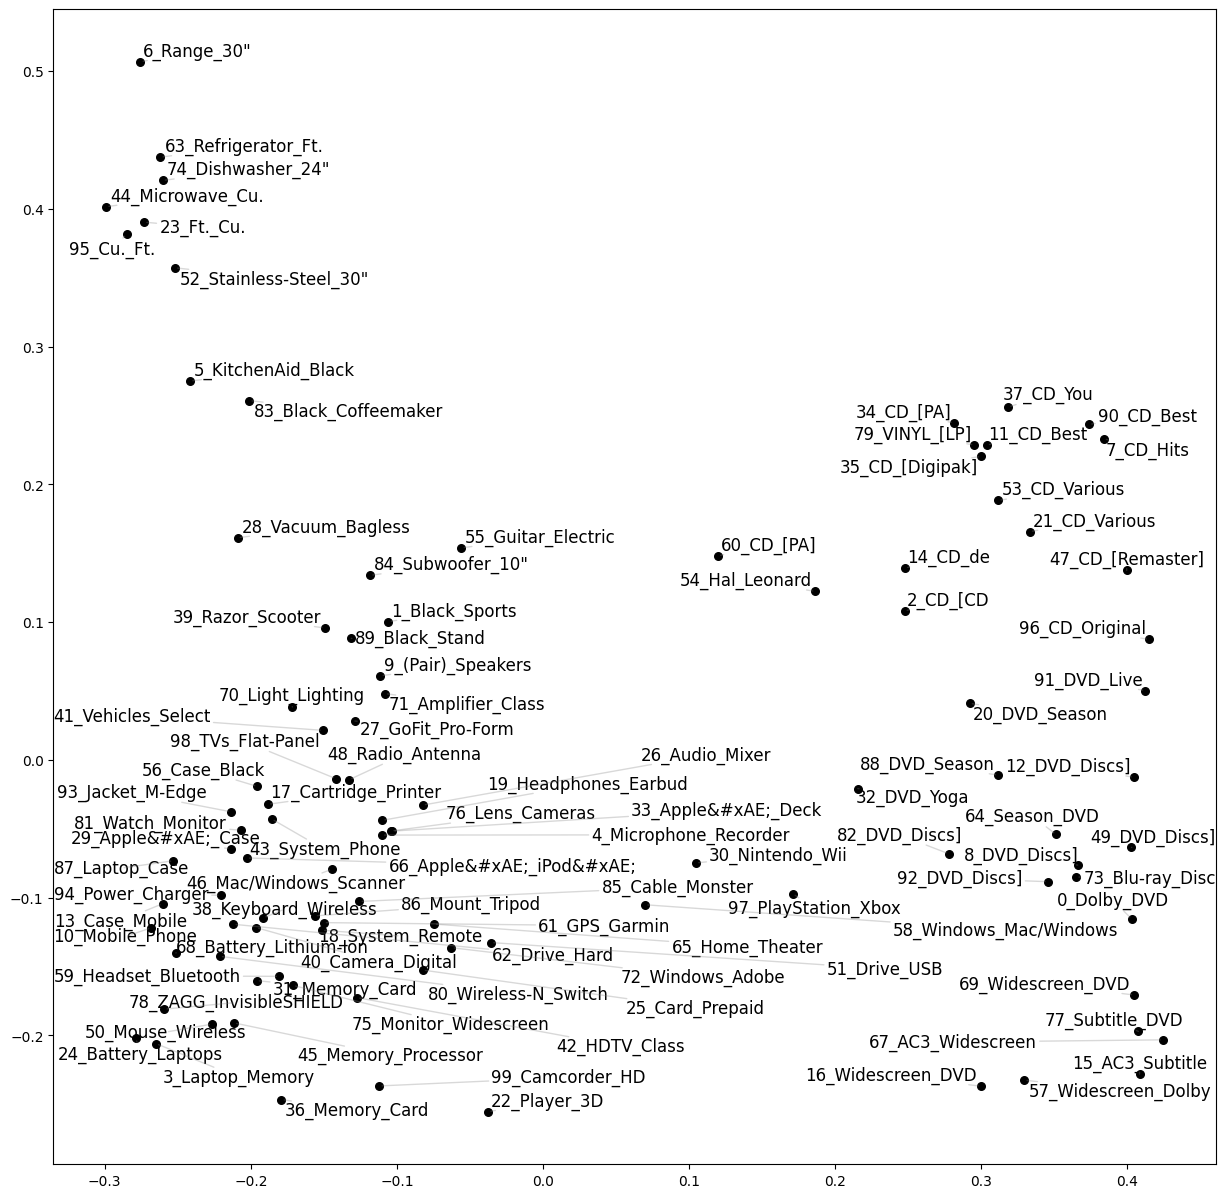

In [12]:
import collections, itertools, numpy as np, matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.decomposition import PCA

stopwords = ["in", "for", "with", "of", "the", "to", "and"]

def top_words(clusters, top_n):
    # Loop through the clusters and split each string on space
    tokenized = [cluster.split() for cluster in clusters]
    # Flatten the list of lists
    flattened = list(itertools.chain.from_iterable(tokenized))
    filtered = [word for word in flattened
                if len(word) > 1 and word.lower() not in stopwords]
    
    # Return the most common words
    return [word for word, _ 
            in collections.Counter(filtered).most_common(top_n)]

#Transform the data for 2-D visualization
plt.figure(figsize=(15, 15))
pca = PCA(100, svd_solver="full")
centers = algo.cluster_centers_
plot_data = pca.fit_transform(centers)

points = []
for i, cluster_name in enumerate(plot_data):
    plt.scatter(plot_data[i, 0], plot_data[i, 1],
                s=30, color="k") 
    label = f"{i}_{'_'.join(top_words(clusters[i], 2))}"
    points.append(plt.text(plot_data[i, 0],
                           plot_data[i, 1],
                           label, size=12))
adjust_text(points, arrowprops=dict(arrowstyle="-",
                          color="gray", alpha=0.3))

In [13]:
clusters[1]  #useful for spot checking clusters to ensure items inside are homogenous

['3drumsticks - 5B Drumsticks (3-Pack) - Natural',
 'Allsop - Ergoprene Gel Wrist Rest - Blue',
 'Anji Mountain Bamboo Chairmat & Rug Co. - 36" x 48" Bamboo Roll-Up Chair Mat - Natural',
 'Anji Mountain Bamboo Chairmat & Rug Co. - 48" x 52" Bamboo Roll-Up Chair Mat - Natural',
 'Anji Mountain Bamboo Chairmat & Rug Co. - 55" x 57" Bamboo Roll-Up Chair Mat - Natural',
 'Armpocket - Sport 20 Arm Band - Navy Blue',
 'As Seen On TV - Criss Angel Mindfreak Platinum Magic Kit',
 'As Seen On TV - Heeltastic',
 'As Seen On TV - Instyler',
 'As Seen On TV - Pillow Pets Dog - Brown',
 'As Seen On TV - Windshield Wonder',
 'As Seen On TV - Wonder Hangers (8-Pack)',
 'Ashlin - Slim Barrister Tower - Black',
 'Ashlin - Slim Barrister Tower - Cherry/Black',
 'Atlantic - 2-Disc Media Sleeves (20-Pack) - Blue/Red/Green/Yellow',
 'Atlantic - 80-Disc File Cube - Gray Frost',
 'Atlantic - Colored Music Sleeves (20-Pack) - Blue/Red/Yellow/Green',
 'Atomic9 - RumbleBuds (Black)',
 'Atomic9 - RumbleBuds (Whi

In [14]:
#sample top keywords in each cluster (same as figure above, but more data)
for cluster_key in range(0,99):
    print(f"{{ cluster: {cluster_key}, top_words: {top_words(clusters[cluster_key], 20)}}}")

{ cluster: 0, top_words: ['Dolby', 'DVD', 'Widescreen', 'AC3', 'Subtitle', 'Fullscreen', 'Blu-ray', 'Disc', 'Dts', 'Dubbed', 'Special', 'Discs]', 'Sub', 'Dub', 'Dol)', '(Ws', 'Vol.', 'WWE:', '[3', 'Ac3']}
{ cluster: 1, top_words: ['Black', 'Sports', 'Red', 'Eyewear', 'Gunnar', 'Clock', 'Blue', 'Game', 'T-Shirt', 'Silver', 'Innovations', 'Pangea', 'Pillow', 'Fabrique', 'Team', 'Iron', 'America', 'Pet', 'Kit', 'White']}
{ cluster: 2, top_words: ['CD', '[CD', 'DVD]', '[PA]', '[Digipak]', 'Icon', '(CD+DVD)', '[Import]', 'Live', '[ECD]', 'It', '[Box]', 'Black', 'Init&#x2122;', 'Home', 'On', '[Slipcase]', 'Wallet', 'Play', 'CD]']}
{ cluster: 3, top_words: ['Laptop', 'Memory', 'Processor', 'Display', 'Drive', 'Hard', 'Intel&#xAE;', '4GB', 'Core&#x2122;', '15.6"', 'Black', 'HP', '500GB', 'AMD', '14"', '640GB', '6GB', 'i3', 'i5', 'Toshiba']}
{ cluster: 4, top_words: ['Microphone', 'Recorder', 'Digital', 'Voice', 'Condenser', 'Black', 'USB', 'Studio', 'Wireless', 'Vocal', 'Dynamic', 'Blue', 'Sys

In [15]:
import pandas 

### Create Pandas dataframes for product_clusters
product_ids_labels = dict(zip(product_ids, labels))
pddf_product_ids_labels = pandas.DataFrame.from_dict(product_ids_labels, orient="index", columns=["label"])
pddf_product_ids_labels["pid"] = pddf_product_ids_labels.index

## Listing 9.15 Comparing approaches for mapping queries to product clusters

In [16]:
import sentence_transformers, heapq

## get the top n clusters based on similairty with centers 
def get_top_labels_centers(query, centers, n=2):
    query_embedding = transformer.encode([query], convert_to_tensor=False)
    similarities = sentence_transformers.util.cos_sim(
                              query_embedding, centers)
    sim = similarities.tolist()[0]
    return [sim.index(i) for i in heapq.nlargest(n, sim)]

### Get the cluster for the query based on prediction of the label
def get_query_cluster(query):
    query_embedding = transformer.encode([query], convert_to_tensor=False)
    return algo.predict(query_embedding)

def get_cluster_description(cluser_num):
    return "_".join(top_words(clusters[cluser_num], 5))

In [17]:
random.seed(0)

query = "microwave"
#option 1: Find nearest cluster (KMeans)
kmeans_predict = get_query_cluster(query)[0]
print("KMeans Predicted Cluster:")
print(f"    {kmeans_predict} ({get_cluster_description(kmeans_predict)})")

#option 2: Find most similar cluster (Cosine similarity)
closest_cosine_similarity = get_top_labels_centers(query, centers, 1)[0]
print(f"""\nCosine Predicted Cluster:\n    {closest_cosine_similarity}
      {get_cluster_description(closest_cosine_similarity)})""")

#option 3: N-nearest clusters (Cosine similarity)
knn_cosine_similarity = get_top_labels_centers(query, centers, 5)
print(f"\nKNN Cosine Predicted Clusters: {knn_cosine_similarity}")
for n in knn_cosine_similarity:
      print(f"    {n} ({get_cluster_description(n)})")

KMeans Predicted Cluster:
    44 (Microwave_Cu._Ft._Stainless-Steel_Oven)

Cosine Predicted Cluster:
    44
      Microwave_Cu._Ft._Stainless-Steel_Oven)

KNN Cosine Predicted Clusters: [44, 52, 5, 83, 6]
    44 (Microwave_Cu._Ft._Stainless-Steel_Oven)
    52 (Stainless-Steel_30"_Black_Range_Cooktop)
    5 (KitchenAid_Black_White_Stand_Mixer)
    83 (Black_Coffeemaker_Maker_Coffee_Stainless-Steel)
    6 (Range_30"_Self-Cleaning_Freestanding_Stainless-Steel)


In [18]:
sdf_id_labels = spark.createDataFrame(pddf_product_ids_labels).createOrReplaceTempView('products_clusters')

In [19]:
# Load signal data to create user-product vectors
signals_collection = engine.get_collection("signals")
create_view_from_collection(signals_collection, "signals", spark)

In [20]:
#Create User-product data set for personalization
spark.sql("""SELECT DISTINCT user, target AS product_id, name AS product_name
FROM signals s JOIN products_samples p ON s.target = p.upc
WHERE s.type = 'click'""").createOrReplaceTempView("user_product")

query = """SELECT user, product_id, product_name, label FROM user_product a
JOIN products_clusters b ON a.product_id = b.pid"""

user_product_cluster_collection = engine.create_collection("user_product_cluster")
user_product_cluster_collection.write(from_sql(query, spark))

Wiping "user_product_cluster" collection
Creating "user_product_cluster" collection
Status: Success
Successfully written 431392 documents


## Listing 9.16

In [21]:
## get the top n clusters based on similarity with centers 
def top_clusters_for_embedding(embedding, n=2):
    similarities = sentence_transformers.util.cos_sim(embedding, centers)
    sim = similarities.tolist()[0]
    return [sim.index(i) for i in heapq.nlargest(n, sim)]

In [22]:
# importiong the modules

#Take user's product interests and return dataframe containing embedding and guardrail cluster
def get_user_embeddings(products=[]):
    values = []
    embeddings = get_indexed_product_embeddings()
    for p in products:
        values.append([embeddings[p], top_clusters_for_embedding(embeddings[p], 1)[0]])

    return pandas.DataFrame(data=values, index=products,
                            columns=["embedding", "cluster"])

def get_personalization_vector(query=None,
                            user_items=[],
                           query_weight=1,
                    user_items_weights=[]):
    #by default, weight is split 1:1 (50% each) between the query embedding and the user_items_weight.
    #you can manually add weights for each user_item to influence how much each element counts.

    query_embedding = transformer.encode(query) if query else None
    
    if len(user_items) > 0 and len(user_items_weights) == 0:
        user_items_weights = numpy.full(shape=len(user_items),
                               fill_value=1 / len(user_items))
            
    embeddings = []
    embedding_weights = []
    for weight in user_items_weights:
        embedding_weights.append(weight) 
    for embedding in user_items:
        embeddings.append(embedding)
    if query_embedding.any():
        embedding_weights.append(query_weight)
        embeddings.append(query_embedding)
    
    return numpy.average(embeddings, weights=numpy.array(embedding_weights),
                         axis=0).astype("double") if len(embeddings) else None

## Listing 9.17

In [23]:
def format_vector(vector):
    return "[" + (", ".join([str(round(n, 3)) for n in vector]))[0:70] + " ...]"

In [24]:
product_interests = ["7610465823828",  #hello kitty water bottle
                     "36725569478"]   #stainless steel electric range

user_embeddings = get_user_embeddings(product_interests)
print(f"\nProducts Interactions for Personalization:\n {user_embeddings}")
query = "microwave"

unfiltered_personalization_vector = get_personalization_vector(query=query,
                        user_items=user_embeddings['embedding'].to_numpy())
print("\nPersonalization Vector (No Cluster Guardrails):")
print(format_vector(unfiltered_personalization_vector))

query_clusters = get_top_labels_centers(query,
                                 centers, n=5)
print("\nQuery Clusters ('microwave'):\n" + str(query_clusters))

clustered = user_embeddings.cluster.isin(query_clusters)
products_in_cluster = user_embeddings[clustered] #filter down to only items in the query clusters
print("\nProducts Filtered to Query Clusters:\n" + str(products_in_cluster))

filtered_personalization_vector = get_personalization_vector(query=query,
                             user_items=products_in_cluster['embedding'].to_numpy())
print("\nFiltered Personalization Vector (With Cluster Guardrails):")
print(format_vector(filtered_personalization_vector))


Products Interactions for Personalization:
                                                        embedding  cluster
7610465823828  [0.06417941, 0.04178553, -0.0017139615, -0.020...        1
36725569478    [0.0055417763, -0.024302201, -0.024139373, -0....        6

Personalization Vector (No Cluster Guardrails):
[0.016, -0.006, -0.02, -0.032, -0.016, 0.008, -0.0, 0.017, 0.011, 0.007 ...]

Query Clusters ('microwave'):
[44, 52, 5, 83, 6]

Products Filtered to Query Clusters:
                                                     embedding  cluster
36725569478  [0.0055417763, -0.024302201, -0.024139373, -0....        6

Filtered Personalization Vector (With Cluster Guardrails):
[0.002, -0.023, -0.026, -0.037, -0.025, 0.002, -0.009, 0.007, 0.033, -0 ...]


## Listing 9.18

In [25]:
# %load -s product_search_request engine/search_functions
def product_search_request(query, param_overrides={}):
    request = {"query": query,
               "query_fields": ["name", "manufacturer", "long_description"],
               "return_fields": ["upc", "name", "manufacturer",
                                 "short_description", "score"],
               "limit": 5,
               "order_by": [("score", "desc"), ("upc", "asc")]}
    return request | param_overrides

In [26]:
from operator import itemgetter

def rerank_with_personalization(docs, personalization_vector):
    embeddings = get_indexed_product_embeddings()
    result_embeddings = numpy.array(
        [embeddings[docs[x]['upc']]
         for x in range(len(docs))]).astype(float)
    similarities = sentence_transformers.util.cos_sim(
        personalization_vector, result_embeddings).tolist()[0]
    reranked = [similarities.index(i)
                for i in heapq.nlargest(len(similarities), similarities)]
    reranked, _ = zip(*sorted(enumerate(similarities),
                              key=itemgetter(1), reverse=True))
    return [docs[i] for i in reranked]

In [27]:
query = "microwave"
request = product_search_request(query, {"limit": 100})

response = products_collection.search(**request)
docs = response["docs"]
print("No Personalization:")
display_product_search(query, docs[0:4])

No Personalization:


In [28]:
print("Global Personalization (No Category Guardrails):")
reranked_seach_results_no_guardrails = \
    rerank_with_personalization(docs,
        unfiltered_personalization_vector) 
display_product_search(query, reranked_seach_results_no_guardrails[0:4])

Global Personalization (No Category Guardrails):


In [29]:
print("Contextual Personalization (with Category Guardrails):")
reranked_seach_results_with_guardrails = \
    rerank_with_personalization(docs,
        filtered_personalization_vector) 
display_product_search(query, reranked_seach_results_with_guardrails[0:4])

Contextual Personalization (with Category Guardrails):


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 51880)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/

Up next: Chapter 10 - [Learning to Rank for Generalizable Search Relevance](../ch10/1.setup-the-movie-db.ipynb)